In [3]:
import pandas as pd
df=pd.read_csv('/content/IndianFlightdata - Sheet1.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


# **method 2.**

splitting

In [7]:
from sklearn.model_selection import train_test_split

x = df.iloc[:, [0, 1, 2, 3, 5, 6, 7]]
y = df.iloc[:, 4]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.info()
x_train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8545 entries, 10005 to 7270
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Airline         8545 non-null   object 
 1   Source          8545 non-null   object 
 2   Destination     8545 non-null   object 
 3   Total_Stops     8545 non-null   object 
 4   day_of_week     8545 non-null   object 
 5   dep_hour        8545 non-null   int32  
 6   Duration_hours  8545 non-null   float64
dtypes: float64(1), int32(1), object(5)
memory usage: 500.7+ KB


,Airline,Source,Destination,Total_Stops,day_of_week,dep_hour,Duration_hours
10005,Multiple carriers,Delhi,Cochin,1 stop,Monday,8,10.750000
3684,Jet Airways,Delhi,Cochin,1 stop,Thursday,11,25.083333
1034,SpiceJet,Delhi,Cochin,1 stop,Wednesday,15,6.333333
3909,Multiple carriers,Delhi,Cochin,1 stop,Thursday,12,12.750000
3088,Air India,Delhi,Cochin,2 stops,Monday,17,26.000000


#  Feature Engineering & Pipeline Design


### 1. Custom Time-of-Day Binning (`dep_hour`)
* Grouping hours into 6-hour windows (Night, Morning, Afternoon, Evening).
 Followed by **One-Hot Encoding** to treat these time blocks as independent categories.

### 2. Log Transformation (`duration`)

* The duration data is **right-skewed**



### 3. One-Hot Encoding (Categorical Columns)
* encoding `Airline`, `Source`, and `Destination` .


### 4. Ordinal Encoding (`total_stops`)
* total stops follows a order

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,OrdinalEncoder
import numpy as np

def manual_bins(X):
    # This creates edges: 0-6, 7-12, 13-18, 19-24
    bins = [-1, 6, 12, 18, 24]
    # We return a 2D array of the bin indices (0, 1, 2, or 3)
    return pd.cut(X.iloc[:, 0], bins=bins, labels=False).values.reshape(-1, 1)

binning_step = FunctionTransformer(manual_bins, feature_names_out='one-to-one')
transformer1=FunctionTransformer(func=np.log1p,feature_names_out='one-to-one')
transformer2=PowerTransformer(method='yeo-johnson')
tranformer=ColumnTransformer(transformers=[
    ('encoding',OneHotEncoder(sparse_output=False,drop='first'),[0,1,2,4]),
    ('func',transformer1,[6]),
    ('bin',binning_step,[5]),
    ('func2',OneHotEncoder(sparse_output=False,drop='first'),[5]),
    ('ord_enc',OrdinalEncoder(categories=[['non-stop','1 stop', '2 stops', '3 stops', '4 stops']]),[3])
],remainder='passthrough')

x_train=tranformer.fit_transform(x_train)
x_test=tranformer.transform(x_test)

In [9]:
x_train.shape

(8545, 52)

In [10]:
y_train=transformer1.fit_transform(y_train.values)
y_test=transformer1.transform(y_test.values)

showing x_train

In [11]:
import pandas as pd
new_column_names = tranformer.get_feature_names_out()
x_train_final = pd.DataFrame(x_train, columns=new_column_names)
x_train_final.head()

,encoding__Airline_Air India,encoding__Airline_GoAir,encoding__Airline_IndiGo,encoding__Airline_Jet Airways,encoding__Airline_Jet Airways Business,encoding__Airline_Multiple carriers,encoding__Airline_Multiple carriers Premium economy,encoding__Airline_SpiceJet,encoding__Airline_Trujet,encoding__Airline_Vistara,...,func2__dep_hour_15,func2__dep_hour_16,func2__dep_hour_17,func2__dep_hour_18,func2__dep_hour_19,func2__dep_hour_20,func2__dep_hour_21,func2__dep_hour_22,func2__dep_hour_23,ord_enc__Total_Stops
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


**observing new dept_hour**

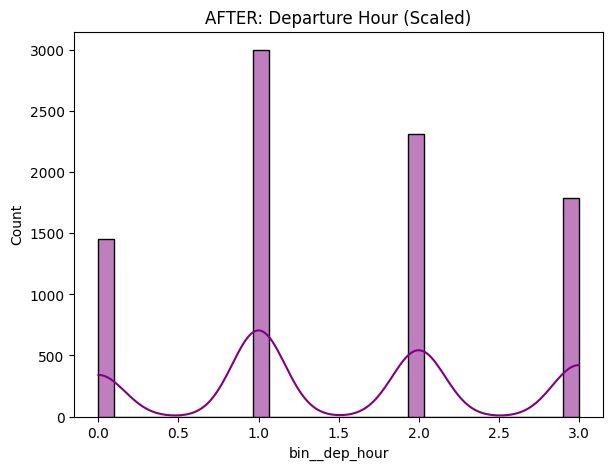

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
hour_col = x_train_final.filter(like='dep_hour').columns[0]
sns.histplot(x_train_final[hour_col], kde=True, color='purple')
plt.title("AFTER: Departure Hour (Scaled)")
plt.show()

# **prediction**

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'KNN': KNeighborsRegressor()
}

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"--- {name} ---")
    print(f"R2 Score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print("-" * 20)

--- Linear Regression ---
R2 Score: 0.7248
Mean Absolute Error: 0.21
--------------------
--- Random Forest ---
R2 Score: 0.7680
Mean Absolute Error: 0.17
--------------------
--- KNN ---
R2 Score: 0.7528
Mean Absolute Error: 0.19
--------------------


# ***pca***

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error

results_list = []

ranges = [range(1, 11), range(20, 31), range(30, 41), range(40, 51)]

for r in ranges:
    for n in r:
        pca = PCA(n_components=n)
        x_train_pca = pca.fit_transform(x_train)
        x_test_pca = pca.transform(x_test)

        models = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(),
            'KNN': KNeighborsRegressor()
        }

        for name, model in models.items():
            model.fit(x_train_pca, y_train)
            y_pred = model.predict(x_test_pca)

            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)

            results_list.append({
                'n_components': n,
                'model': name,
                'r2': r2,
                'mae': mae
            })
        print(f"Completed n_components: {n}")

Completed n_components: 1
Completed n_components: 2
Completed n_components: 3
Completed n_components: 4
Completed n_components: 5
Completed n_components: 6
Completed n_components: 7
Completed n_components: 8
Completed n_components: 9
Completed n_components: 10
Completed n_components: 20
Completed n_components: 21
Completed n_components: 22
Completed n_components: 23
Completed n_components: 24
Completed n_components: 25
Completed n_components: 26
Completed n_components: 27
Completed n_components: 28
Completed n_components: 29
Completed n_components: 30
Completed n_components: 30
Completed n_components: 31
Completed n_components: 32
Completed n_components: 33
Completed n_components: 34
Completed n_components: 35
Completed n_components: 36
Completed n_components: 37
Completed n_components: 38
Completed n_components: 39
Completed n_components: 40
Completed n_components: 40
Completed n_components: 41
Completed n_components: 42
Completed n_components: 43
Completed n_components: 44
Completed 

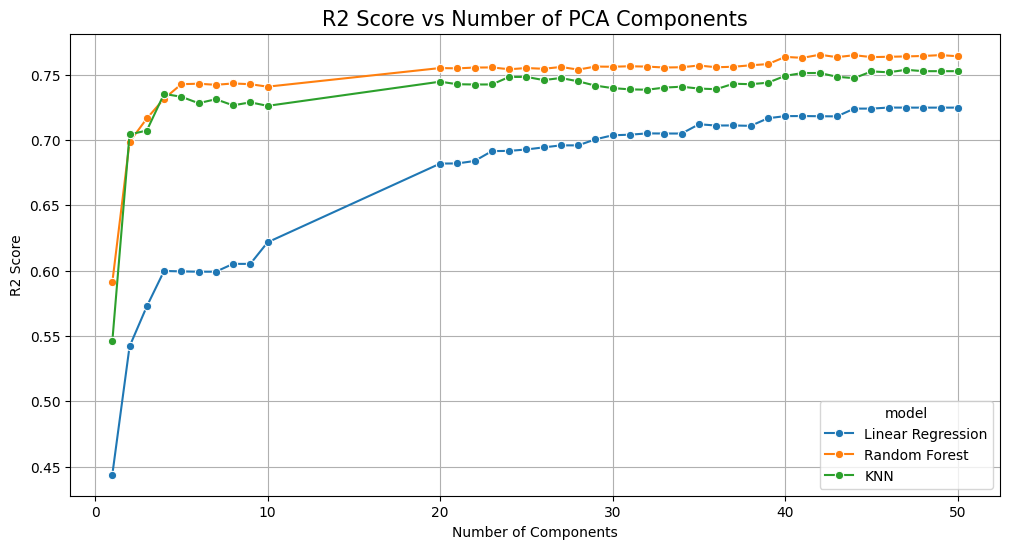

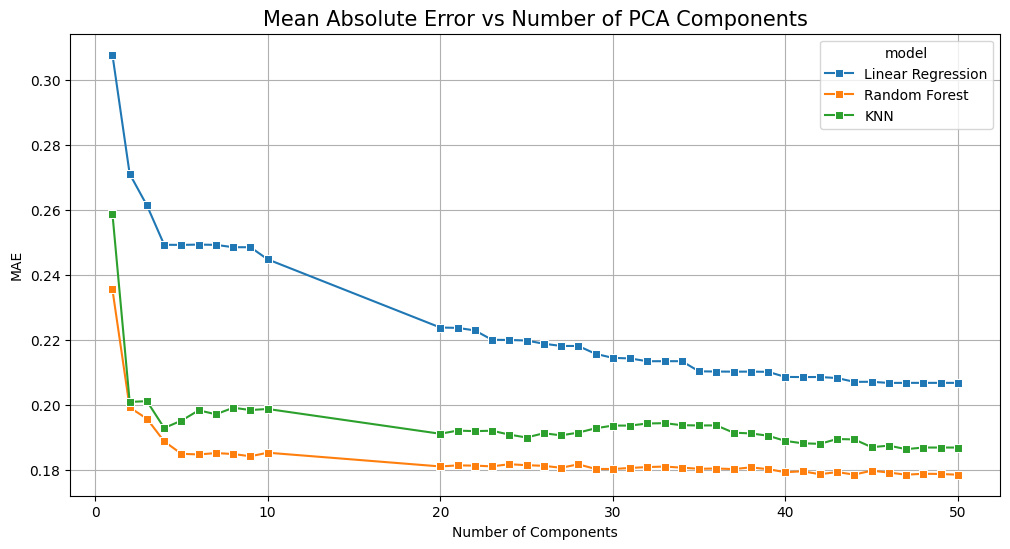

In [16]:
import pandas as pd
import seaborn as sns

results_df = pd.DataFrame(results_list)

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='n_components', y='r2', hue='model', marker='o')
plt.title('R2 Score vs Number of PCA Components', fontsize=15)
plt.ylabel('R2 Score')
plt.xlabel('Number of Components')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='n_components', y='mae', hue='model', marker='s')
plt.title('Mean Absolute Error vs Number of PCA Components', fontsize=15)
plt.ylabel('MAE')
plt.xlabel('Number of Components')
plt.grid(True)
plt.show()